<a href="https://colab.research.google.com/github/veerendra12/CS598-DL4H-Project/blob/main/notebooks/SDFNPipeLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def mount_drive():
  from google.colab import drive
  drive.mount('/content/drive')

mount_drive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def copy_code_from_drive():
  DRIVE_NOTBOOKS_DIR = '/content/drive/MyDrive/Colab Notebooks/'.replace(' ', '\\ ')

  # Copy the notebooks from drive to colab cwd
  Configuration_ipynb = DRIVE_NOTBOOKS_DIR + 'Configuration.ipynb'
  !cp $Configuration_ipynb '/content' 

  # Copy the notebooks from drive to colab cwd
  Utils_ipynb = DRIVE_NOTBOOKS_DIR + 'Utils.ipynb'
  !cp $Utils_ipynb '/content' 

  TrainEvalUtil_ipynb = DRIVE_NOTBOOKS_DIR + 'TrainEvalUtil.ipynb'
  !cp $TrainEvalUtil_ipynb '/content' 

  NIHPreprocessor_ipynb = DRIVE_NOTBOOKS_DIR + 'NIHPreprocessor.ipynb'
  !cp $NIHPreprocessor_ipynb '/content' 

  NIHDataSet_ipynb = DRIVE_NOTBOOKS_DIR + 'NIHDataSet.ipynb'
  !cp $NIHDataSet_ipynb '/content' 

  ModelFactory_ipynb = DRIVE_NOTBOOKS_DIR + 'ModelFactory.ipynb'
  !cp $ModelFactory_ipynb '/content' 

  LungRegionGenerator_ipynb = DRIVE_NOTBOOKS_DIR + 'LungRegionGenerator.ipynb'
  !cp $LungRegionGenerator_ipynb '/content' 

copy_code_from_drive()

In [ ]:
def install_libraries():
  !pip install -U albumentations
  !pip uninstall opencv-python-headless --yes
  !pip install opencv-python-headless==4.5.2.52
  !pip list | grep opencv
  !pip install gputil
  !pip install psutil
  !pip install humanize
  !pip install import-ipynb
install_libraries()

In [ ]:
import import_ipynb

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from Configuration import CONFIG
from Utils import get_device, memory_report, copy_data_from_drive, load_checkpoint
from TrainEvalUtil import train_model, eval_model, compute_auc, plot_epoch_loss
from NIHPreprocessor import prepare_NIH_dataset, generate_train_test_split
from NIHDataSet import get_NIH_FullCXR_loaders, get_NIH_LungRegion_loaders
from ModelFactory import get_densenet121_model, get_sdfn_model

importing Jupyter notebook from Configuration.ipynb
importing Jupyter notebook from Utils.ipynb
importing Jupyter notebook from TrainEvalUtil.ipynb
importing Jupyter notebook from NIHPreprocessor.ipynb
importing Jupyter notebook from NIHDataSet.ipynb
importing Jupyter notebook from LungRegionGenerator.ipynb
importing Jupyter notebook from ModelFactory.ipynb


In [ ]:
get_device()

'cuda'

In [ ]:
def get_model():
  if (CONFIG['MODEL_TYPE'] == 'SDFN'):
    return get_sdfn_model()
  if (CONFIG['MODEL_TYPE'] == 'FEM'):
    return get_densenet121_model()

In [ ]:
def train_main():
  copy_data_from_drive()
  
  BASE_DIR = CONFIG['BASE_DIR']
  checkpoint_prefix = CONFIG['RUN_PREFIX']

  if CONFIG['USE_LUNG_REGION_GENERATOR']:
    train_dataset, train_loader, validation_dataset, validation_loader = get_NIH_LungRegion_loaders()
  else:
    train_dataset, train_loader, validation_dataset, validation_loader = get_NIH_FullCXR_loaders()
    

  dataloaders_dict = {
      'train': train_loader,
      'validation': validation_loader
      }

  model = get_model()

  if (CONFIG['RESUME_TRAINING']):
    resume_idx = CONFIG['EPOCH_START']-1
    print("*****Resuming training from " + str(CONFIG['EPOCH_START']) + ", loading " + "results/" + checkpoint_prefix + str(resume_idx) + ".pth")
    load_checkpoint(model, BASE_DIR + "results/" + checkpoint_prefix + str(resume_idx) + ".pth")

  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['LEARNING_RATE'])

  model, results = train_model(model, 
                               train_loader, 
                               validation_loader, 
                               optimizer, 
                               criterion, 
                               checkpoint_prefix=checkpoint_prefix) 

  plot_epoch_loss(results)

  print("******AUC for last fit model...")
  pred_df, true_df = eval_model(model, validation_dataset, validation_loader)
  compute_auc(pred_df, true_df)

  print("******AUC for best fit model...")
  model = get_model()
  best_model_idx = results['Validation Loss'].idxmin()
  load_checkpoint(model, BASE_DIR + "results/" + checkpoint_prefix + str(best_model_idx) + ".pth")
  pred_df, true_df = eval_model(model, validation_dataset, validation_loader)
  compute_auc(pred_df, true_df)

In [ ]:
def evaluate_main():
  copy_data_from_drive()
  
  BASE_DIR = CONFIG['BASE_DIR']
  checkpoint_prefix = CONFIG['RUN_PREFIX']

  model = get_model()

  if CONFIG['USE_LUNG_REGION_GENERATOR']:
    train_dataset, train_loader, validation_dataset, validation_loader = get_NIH_LungRegion_loaders()
  else:
    train_dataset, train_loader, validation_dataset, validation_loader = get_NIH_FullCXR_loaders()

  if(CONFIG['MODEL_TYPE'] == 'FEM'):
    if CONFIG['USE_LUNG_REGION_GENERATOR']:
      load_checkpoint(model, CONFIG['FEM2_BEST_MODEL'])
    else:
      load_checkpoint(model, CONFIG['FEM1_BEST_MODEL'])
  elif(CONFIG['MODEL_TYPE'] == 'SDFN'):
    load_checkpoint(model, CONFIG['SDFN_BEST_MODEL'])

  pred_df, true_df = eval_model(model, validation_dataset, validation_loader)
  compute_auc(pred_df, true_df)

Using get_NIH_LungRegion_loaders
=> Loading checkpoint /content/DataSets/LungSegmentationDataset/results/unet_chesxray_mcu_8.pth
=> Loading checkpoint /content/DataSets/LungSegmentationDataset/results/unet_chesxray_mcu_8.pth
Epoch 0: Train curr_epoch_loss=0.16654860995154358
Training complete in 34m 46s
Epoch 0: Validate curr_epoch_loss=0.1801604597049416
Validation complete in 6m 59s
10645.0
Epoch 1: Train curr_epoch_loss=0.15314252886693902
Training complete in 34m 34s
Epoch 1: Validate curr_epoch_loss=0.1744318385043855
Validation complete in 6m 58s
9871.0
Epoch 2: Train curr_epoch_loss=0.14869634601109122
Training complete in 34m 32s
Epoch 2: Validate curr_epoch_loss=0.18032357584520345
Validation complete in 6m 58s
9871.0
Epoch 3: Train curr_epoch_loss=0.14435203145768147
Training complete in 34m 35s
Epoch 3: Validate curr_epoch_loss=0.17120438262543902
Validation complete in 6m 57s
9871.0
Epoch 4: Train curr_epoch_loss=0.13986848486514972
Training complete in 34m 26s
Epoch 4: Val

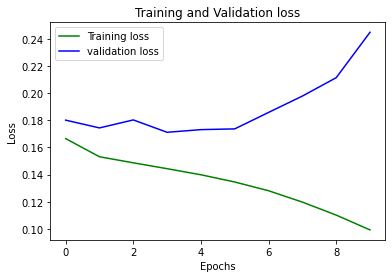

******AUC for last fit model...
                 label       auc
0          Atelectasis  0.755353
1         Cardiomegaly  0.762303
2        Consolidation  0.770484
3                Edema  0.822631
4             Effusion  0.834683
5            Emphysema  0.816998
6             Fibrosis  0.705298
7               Hernia  0.898057
8         Infiltration  0.640982
9                 Mass  0.785285
10              Nodule  0.705572
11  Pleural_Thickening  0.719660
12           Pneumonia  0.681671
13        Pneumothorax  0.808906
******AUC for best fit model...
=> Loading checkpoint /content/DataSets/NIHDataSet/results/fem-2_nih_50pc_3.pth
                 label       auc
0          Atelectasis  0.766582
1         Cardiomegaly  0.850284
2        Consolidation  0.789793
3                Edema  0.838941
4             Effusion  0.839695
5            Emphysema  0.840440
6             Fibrosis  0.724081
7               Hernia  0.871743
8         Infiltration  0.660613
9                 Mass  0.79954

In [7]:
if CONFIG['EVAL_MODE']:
  print('Running in Evaluation Mode')
else:
  print('Running in Training Mode')
  train_main()


In [8]:
!ls /content/DataSets/NIHDataSet/images | wc -l

import numpy as np
import pandas as pd

pd.read_csv('/content/DataSets/NIHDataSet/results/summary.csv')

112120


,Unnamed: 0,Iteration,Training Loss,Validation Loss,Training Time (mns),Validation Time (mns),cpu-ram-free,cuda-memory-allocated,cuda-memory-cached,gpu-0-mem-free,gpu-0-mem-total,gpu-0-mem-util
0,0,0,0.166549,0.180160,34.7705,6.9863,51.5 GB,2.0 GB,4.9 GB,11.2 GB,17.1 GB,0.346%
1,1,1,0.153143,0.174432,34.5656,6.9699,51.5 GB,2.0 GB,5.7 GB,10.4 GB,17.1 GB,0.394%
2,2,2,0.148696,0.180324,34.5410,6.9739,51.5 GB,2.0 GB,5.7 GB,10.4 GB,17.1 GB,0.394%
3,3,3,0.144352,0.171204,34.5798,6.9546,51.8 GB,2.0 GB,5.7 GB,10.4 GB,17.1 GB,0.394%
4,4,4,0.139868,0.173164,34.4335,6.9393,51.8 GB,2.0 GB,5.7 GB,10.4 GB,17.1 GB,0.394%
5,5,5,0.134535,0.173717,34.5031,6.9757,51.8 GB,2.0 GB,5.7 GB,10.4 GB,17.1 GB,0.394%
6,6,6,0.128087,0.185863,34.4497,6.9583,51.8 GB,2.0 GB,5.7 GB,10.4 GB,17.1 GB,0.394%
7,7,7,0.119699,0.197931,34.4736,6.9524,51.8 GB,2.0 GB,5.7 GB,10.4 GB,17.1 GB,0.394%
8,8,8,0.110121,0.211477,34.4576,6.9467,51.8 GB,2.0 GB,5.7 GB,10.4 GB,17.1 GB,0.394%
9,9,9,0.099187,0.245005,34.4969,6.9739,51.8 GB,2.0 GB,5.7 GB,10.4 GB,17.1 GB,0.394%


In [14]:
def copy_result_to_drive():
  !mkdir /content/drive/MyDrive/Colab\ Notebooks/ModelResults/NIHDataSet/FEM2/result_nih_50pc_2
  !cp -v /content/DataSets/NIHDataSet/results/fem-2*.pth /content/drive/MyDrive/Colab\ Notebooks/ModelResults/NIHDataSet/FEM2/result_nih_50pc_2
  !cp -v /content/DataSets/NIHDataSet/results/*.csv /content/drive/MyDrive/Colab\ Notebooks/ModelResults/NIHDataSet/FEM2/result_nih_50pc_2
  !cp -v /content/DataSets/NIHDataSet/fem-2*50*.csv /content/drive/MyDrive/Colab\ Notebooks/ModelResults/NIHDataSet/FEM2/result_nih_50pc_2

# copy_result_to_drive()

'/content/DataSets/NIHDataSet/results/fem-2_nih_50pc_0.pth' -> '/content/drive/MyDrive/Colab Notebooks/ModelResults/NIHDataSet/FEM2/result_nih_50pc_2/fem-2_nih_50pc_0.pth'
'/content/DataSets/NIHDataSet/results/fem-2_nih_50pc_1.pth' -> '/content/drive/MyDrive/Colab Notebooks/ModelResults/NIHDataSet/FEM2/result_nih_50pc_2/fem-2_nih_50pc_1.pth'
'/content/DataSets/NIHDataSet/results/fem-2_nih_50pc_2.pth' -> '/content/drive/MyDrive/Colab Notebooks/ModelResults/NIHDataSet/FEM2/result_nih_50pc_2/fem-2_nih_50pc_2.pth'
'/content/DataSets/NIHDataSet/results/fem-2_nih_50pc_3.pth' -> '/content/drive/MyDrive/Colab Notebooks/ModelResults/NIHDataSet/FEM2/result_nih_50pc_2/fem-2_nih_50pc_3.pth'
'/content/DataSets/NIHDataSet/results/fem-2_nih_50pc_4.pth' -> '/content/drive/MyDrive/Colab Notebooks/ModelResults/NIHDataSet/FEM2/result_nih_50pc_2/fem-2_nih_50pc_4.pth'
'/content/DataSets/NIHDataSet/results/fem-2_nih_50pc_5.pth' -> '/content/drive/MyDrive/Colab Notebooks/ModelResults/NIHDataSet/FEM2/result_n

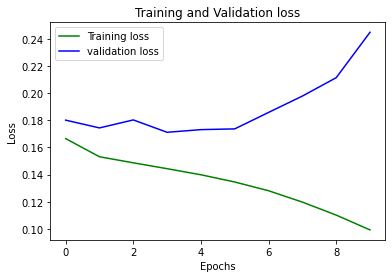

In [10]:
plot_epoch_loss(pd.read_csv(CONFIG['BASE_DIR'] + 'results/summary.csv'))

In [12]:
#plot_epoch_loss(pd.read_csv(CONFIG['BASE_DIR'] + 'results/fem-1_nih_50pc_summary.csv'))

In [13]:
#plot_epoch_loss(pd.read_csv(CONFIG['BASE_DIR'] + 'results/fem-2_nih_50pc_summary.csv'))